In [445]:
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from kmodes import kmodes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl
from sklearn.decomposition import PCA
import random
from scipy.spatial.distance import cdist,pdist
moviesdf1 = pd.read_csv('./ml-latest-small/movies.csv')
ratingsdf = pd.read_csv('./ml-latest-small/ratings.csv')
ratingsdf=ratingsdf.groupby('movieId').filter(lambda x: len(x) >= 10)
ratingsdf=ratingsdf.reset_index(drop=True)


In [446]:
cols_to_be_repeated = ["movieId", "title"]
splitdf = lambda x: x.split('|')
s = moviesdf1.genres.str.split("|").apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
del moviesdf1['genres']
moviesdfnew=moviesdf1.join(pd.DataFrame(s))




In [447]:
moviesdfnew.columns = ['movieId','title','genres']


In [448]:
df=pd.get_dummies(moviesdfnew['genres'])
print (df.head())

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          0         0       0      0   
0                   0       0          0          1         0       0      0   
0                   0       0          0          0         1       0      0   
0                   0       0          0          0         0       1      0   
0                   0       0          0          0         0       0      0   

   Documentary  Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  \
0            0      0        0          0       0     0        0        0   
0            0      0        0          0       0     0        0        0   
0            0      0        0          0       0     0        0        0   
0            0      0        0          0       0     0        0        0   
0            0      0        1          0       0     0        0        0   

   Romance  Sci-Fi  Thriller  War  Western  
0        0 

In [449]:
moviesdf2=df.groupby(df.index).sum()
print (moviesdf2.head())
movies=moviesdf1.join(moviesdf2, lsuffix='_moviesdf1', rsuffix='_moviedsf2')

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   
1                   0       0          1          0         1       0      0   
2                   0       0          0          0         0       1      0   
3                   0       0          0          0         0       1      0   
4                   0       0          0          0         0       1      0   

   Documentary  Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  \
0            0      0        1          0       0     0        0        0   
1            0      0        1          0       0     0        0        0   
2            0      0        0          0       0     0        0        0   
3            0      1        0          0       0     0        0        0   
4            0      0        0          0       0     0        0        0   

   Romance  Sci-Fi  Thriller  War  Western  
0        0 

In [450]:

titles = movies
titles1 = titles.drop(titles.columns[[0, 1]], axis=1, inplace=True)
#print titles
titles1 = titles.as_matrix()
#print titles1[0,3]
#print titles1[0,3]
#print titles1[0,3]
#print titles1


In [451]:
def clusterFilms(titles,flag):
    random.seed(10)
    movieCluster1 = {}
    silscore1 = {}
    for i in range(2,5):
        if flag==1:
            
            movieCluster1[i] = KMeans(n_clusters=i, n_init=5,random_state=1).fit(titles)
            silscore1[i] = silhouette_score(titles, movieCluster1[i].labels_)
        else:
            
            movieCluster1[i] = kmodes.KModes(n_clusters=i, init='Huang', n_init=5).fit(titles)
            silscore1[i] = silhouette_score(titles, movieCluster1[i].labels_)
        
    k=max(silscore1, key=silscore1.get)
    pca = PCA(n_components=2).fit(titles)
    pca_2d = pca.transform(titles)
    plotgraphs(pca_2d,movieCluster1[k],titles,k,pca,flag)
    
            
    return (movieCluster1)[k]
        

In [452]:
def plotgraphs(pca_2d,movieCluster1,titles,i,pca,flag):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18,7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pca_2d) + (i + 1) * 10])
    silhouette_avg = silhouette_score(titles, movieCluster1.labels_)
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(titles, movieCluster1.labels_)
    y_lower = 10
    for j in range(i):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[movieCluster1.labels_ == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(j) / i)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
         # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.spectral(movieCluster1.labels_.astype(float) / i)
    ax2.scatter(pca_2d[:, 0], pca_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)
     # Labeling the clusters
    if flag == 1:
        
        centers = pca.transform(movieCluster1.cluster_centers_)
    else:
        centers = pca.transform(movieCluster1.cluster_centroids_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    for k, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % k, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    if flag==1:
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % i),
                 fontsize=14, fontweight='bold')
    else:
        plt.suptitle(("Silhouette analysis for KModes clustering on sample data "
                  "with n_clusters = %d" % i),
                 fontsize=14, fontweight='bold')
    plt.show()



In [453]:
def withinss(km,flag):
    if flag == 1:
        centroids =(km.cluster_centers_)
    else:
        centroids =(km.cluster_centroids_)
    D_k = [cdist(titles, centroids, 'euclidean')]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/titles.shape[0] for d in dist]
    return avgWithinSS




In [454]:
#moviecluster=clusterFilms(titles)

#ratingsdf.head()
def getUserInfo(ratingsdf,id):
    df = ratingsdf[ratingsdf.userId == id][['movieId','rating']]
    a=pd.DataFrame(df.sort('movieId'))
    a=a.reset_index(drop=True)    
    return a


In [455]:
def setcluster(moviecluster,a):
    df1=pd.DataFrame(moviesdf1.movieId)
    df1['clusterno'] = moviecluster.labels_
    df2 = df1[df1.movieId.isin(a.movieId)]
    df2=df2.reset_index(drop=True)
    a['cluster']=df2.clusterno

    return a

In [456]:
def getmeanratings(a):
    b=pd.DataFrame(a.groupby(a.cluster)['rating'].mean())
    
    c = b[b.rating==max(b.rating)].index
    #print c
    return c


In [457]:
def getrecommendedfilms(c,moviecluster,moviesdf1,a,ratingsdf):
    df1=pd.DataFrame(moviesdf1.movieId)
    df1['clusterno'] = moviecluster.labels_
    df3=df1[df1.clusterno.isin(c)][['movieId']]
    df3 = df3.reset_index(drop=True)
    df3 = df3[~df3.movieId.isin(a.movieId)]
    df3 = df3.reset_index(drop=True)
    d = ratingsdf[ratingsdf.movieId.isin(df3.movieId)]
#b=pd.DataFrame(a.groupby(a.cluster)['rating'].mean())
    d = d.reset_index(drop=True)
    r=pd.DataFrame(d.groupby(d.movieId)['rating'].mean())
    t=moviesdf1[moviesdf1.movieId.isin(r.index)]['title']
    t.index = r.index
    r['title']=t
    #t1=r.sort_values(by='rating',ascending=False)
    #return t1
    return r.sort_values(by='rating',ascending=False)


In [458]:
def recommend(titles,moviesdf1,ratingsdf,userid,number,flag):
    
    moviecluster = clusterFilms(titles,flag)
    #print ("The silhouette score is %f" % (silhouette_score(titles,moviecluster.labels_)))
    print (" The Average within sum of square distance is %f" % (withinss(moviecluster,flag)[0]))
    activeuser = getUserInfo(ratingsdf,userid)
    activeuser = setcluster(moviecluster,activeuser)
    cluster = getmeanratings(activeuser)
    recommend = getrecommendedfilms(cluster,moviecluster,moviesdf1,activeuser,ratingsdf)
#     pcaa = PCA(n_components=2).fit(recommend)
#     pca_2d = pcaa.transform(recommend)
#     for j in range(0, pca_2d.shape[0]):
#                 if cluster.labels_[j] == 0:
#                      c1 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='r',
#                      marker='+')
#                 if cluster.labels_[j]==1:
#                       c2 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='b',
#                      marker='*')
#                 if cluster.labels_[j]==2:
#                       c2 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='g',
#                      marker='o')
#     pl.show()
    top = recommend.head(n = 50).sort_values(by='rating',ascending=False)
    
    
    return top.sample(number)
    

For n_clusters = 3 The average silhouette_score is : 0.23788461793


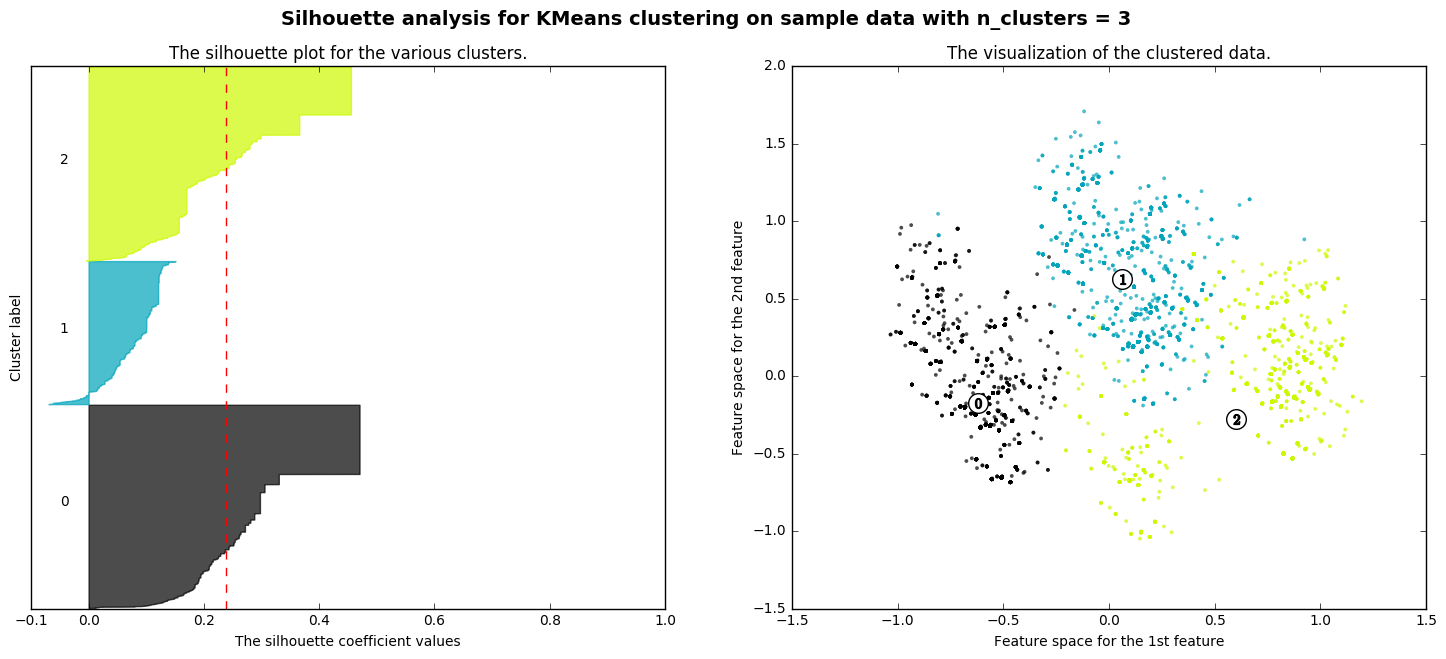

 The Average within sum of square distance is 1.032364


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,rating,title
movieId,,
6016,4.297101,City of God (Cidade de Deus) (2002)
1204,4.215686,Lawrence of Arabia (1962)
1211,4.210526,"Wings of Desire (Himmel über Berlin, Der) (1987)"
475,4.209677,In the Name of the Father (1993)
1280,4.157895,Raise the Red Lantern (Da hong deng long gao g...
2357,4.318182,Central Station (Central do Brasil) (1998)
2202,4.363636,Lifeboat (1944)
2467,4.239130,"Name of the Rose, The (Name der Rose, Der) (1986)"
105504,4.200000,Captain Phillips (2013)


In [459]:
recommend(titles,moviesdf1,ratingsdf,30,10,1) #kmeans



For n_clusters = 3 The average silhouette_score is : 0.23797180289


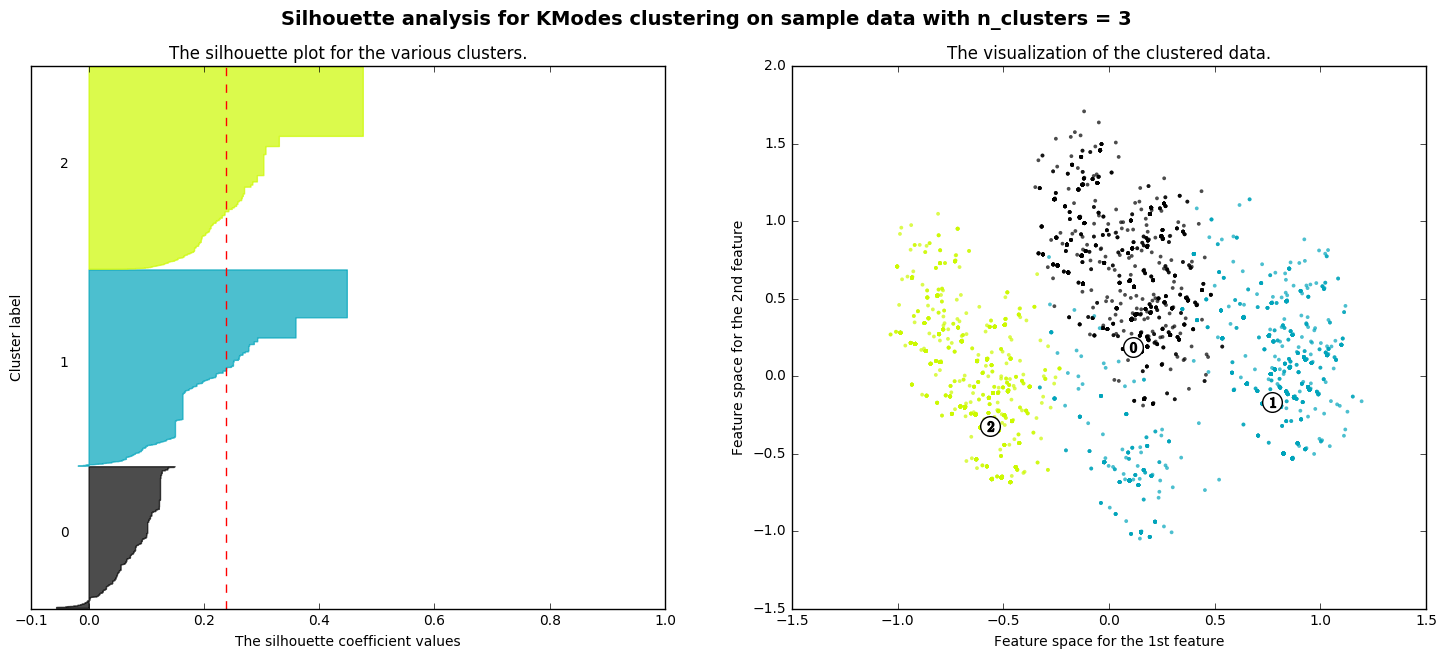

 The Average within sum of square distance is 1.045395


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,rating,title
movieId,,
1233,4.166667,"Boot, Das (Boat, The) (1981)"
1237,4.281250,"Seventh Seal, The (Sjunde inseglet, Det) (1957)"
1411,4.160000,Hamlet (1996)
2648,4.166667,Frankenstein (1931)
1931,4.250000,Mutiny on the Bounty (1935)
1927,4.285714,All Quiet on the Western Front (1930)
233,4.269231,Exotica (1994)
3469,4.541667,Inherit the Wind (1960)
1305,4.291667,"Paris, Texas (1984)"


In [460]:
recommend(titles,moviesdf1,ratingsdf,30,10,0) #kmodes
